In [ ]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import scipy.io as sio
from os import listdir
from os.path import isfile, join
import numpy as np
import keras

from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
import tensorflow as tf

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.models import load_model

In [ ]:
model = load_model('/content/drive/MyDrive/dataset/ecg_model_40_ephos.h5')

In [ ]:
out = pd.read_csv('/content/drive/MyDrive/code_data_major/330hz/esp32_sampleonly_bikesh.csv', header=None)

shape= out.shape
out.shape

(16507, 1)

In [ ]:
out=np.array(out)
out=out.reshape(1,shape[0])

In [ ]:
out=out[:,0:9000]

In [ ]:
beat_calc=out

In [ ]:
out=out.reshape(1,1,9000)

In [ ]:
pre=model.predict(out)

1/1 [==============================] - 0s 87ms/step


In [ ]:
pre

array([[9.9940062e-01, 2.2153583e-06, 5.9714448e-04, 4.3591650e-10]],
      dtype=float32)

In [ ]:
pre.argmax()

0

In [ ]:
out.shape

(1, 1, 9000)

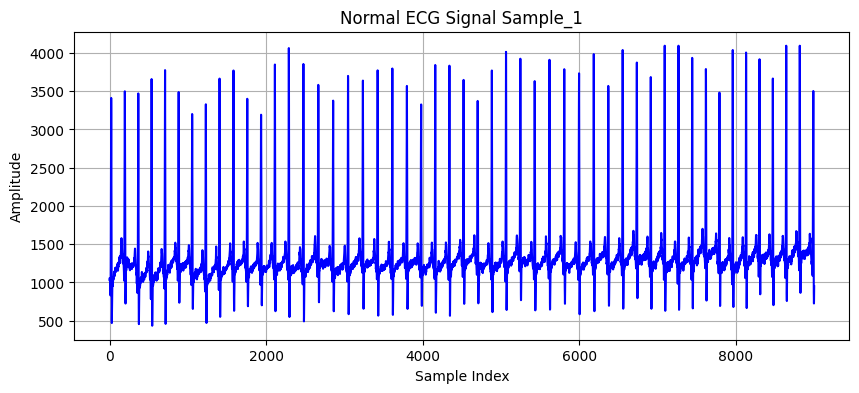

In [ ]:
import matplotlib.pyplot as plt

# Load the array
ecg_data_1 = out

# Plot the ECG signal
plt.figure(figsize=(10, 4))
plt.plot(ecg_data_1.ravel(), color='blue')
plt.title('Normal ECG Signal Sample_1')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, lfilter
import pandas as pd

In [ ]:
ecg_signal= beat_calc

In [ ]:
signal = beat_calc

In [ ]:
# Function to implement a bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=1):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter_bandpass(low, high, order)
    y = lfilter(b, a, data)
    return y

# Helper function for the bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=1):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Function to implement the Pan-Tompkins QRS detection algorithm
def pan_tompkins_filter(ecg_signal, sampling_rate=300):
    # Bandpass filter the signal
    filtered_signal = bandpass_filter(ecg_signal, 0.5, 50.0, sampling_rate)

    # Differentiate the signal
    diff_signal = np.diff(filtered_signal)

    # Squaring
    squared_signal = diff_signal**2

    # Moving Window Integration
    integration_window = int(sampling_rate * 0.100)  # 100 ms window
    integrated_signal = np.convolve(squared_signal, np.ones(integration_window)/integration_window, mode='same')

    # Find peaks in the integrated signal
    peaks, _ = find_peaks(integrated_signal, height=0.005, distance=int(sampling_rate * 0.6))

    return  peaks

In [ ]:
print(ecg_signal.shape)

(1, 9000)


In [ ]:
signal = ecg_signal.reshape(-1)

In [ ]:
print(signal.shape)

(9000,)


In [ ]:
peaks = pan_tompkins_filter(signal)

In [ ]:
peaks

array([  15,  368,  710, 1055, 1404, 1588, 1936, 2288, 2474, 2664, 2854,
       3044, 3235, 3426, 3610, 3798, 3981, 4337, 4522, 4881, 5066, 5248,
       5430, 5621, 5806, 5994, 6185, 6369, 6555, 6737, 6918, 7266, 7448,
       7640, 7957, 8300, 8644, 8984])

In [ ]:
peak_times = peaks / 300  # Convert peak indices to time (seconds)
peak_intervals = np.diff(peak_times) # Compute time intervals between peaks

# Convert time intervals to beats per minute (BPM)
heartbeat_rates = 60 / peak_intervals  # Convert intervals to BPM

# Print heartbeat rates
print("Heartbeat Rates (BPM):", heartbeat_rates)

# Calculate average heartbeat rate
average_heartbeat_rate = int(np.mean(heartbeat_rates))
print("Average Heartbeat Rate (BPM):", average_heartbeat_rate)

Heartbeat Rates (BPM): [50.99150142 52.63157895 52.17391304 51.57593123 97.82608696 51.72413793
 51.13636364 96.77419355 94.73684211 94.73684211 94.73684211 94.2408377
 94.2408377  97.82608696 95.74468085 98.36065574 50.56179775 97.2972973
 50.13927577 97.2972973  98.9010989  98.9010989  94.2408377  97.2972973
 95.74468085 94.2408377  97.82608696 96.77419355 98.9010989  99.44751381
 51.72413793 98.9010989  93.75       56.78233438 52.47813411 52.3255814
 52.94117647]
Average Heartbeat Rate (BPM): 80
